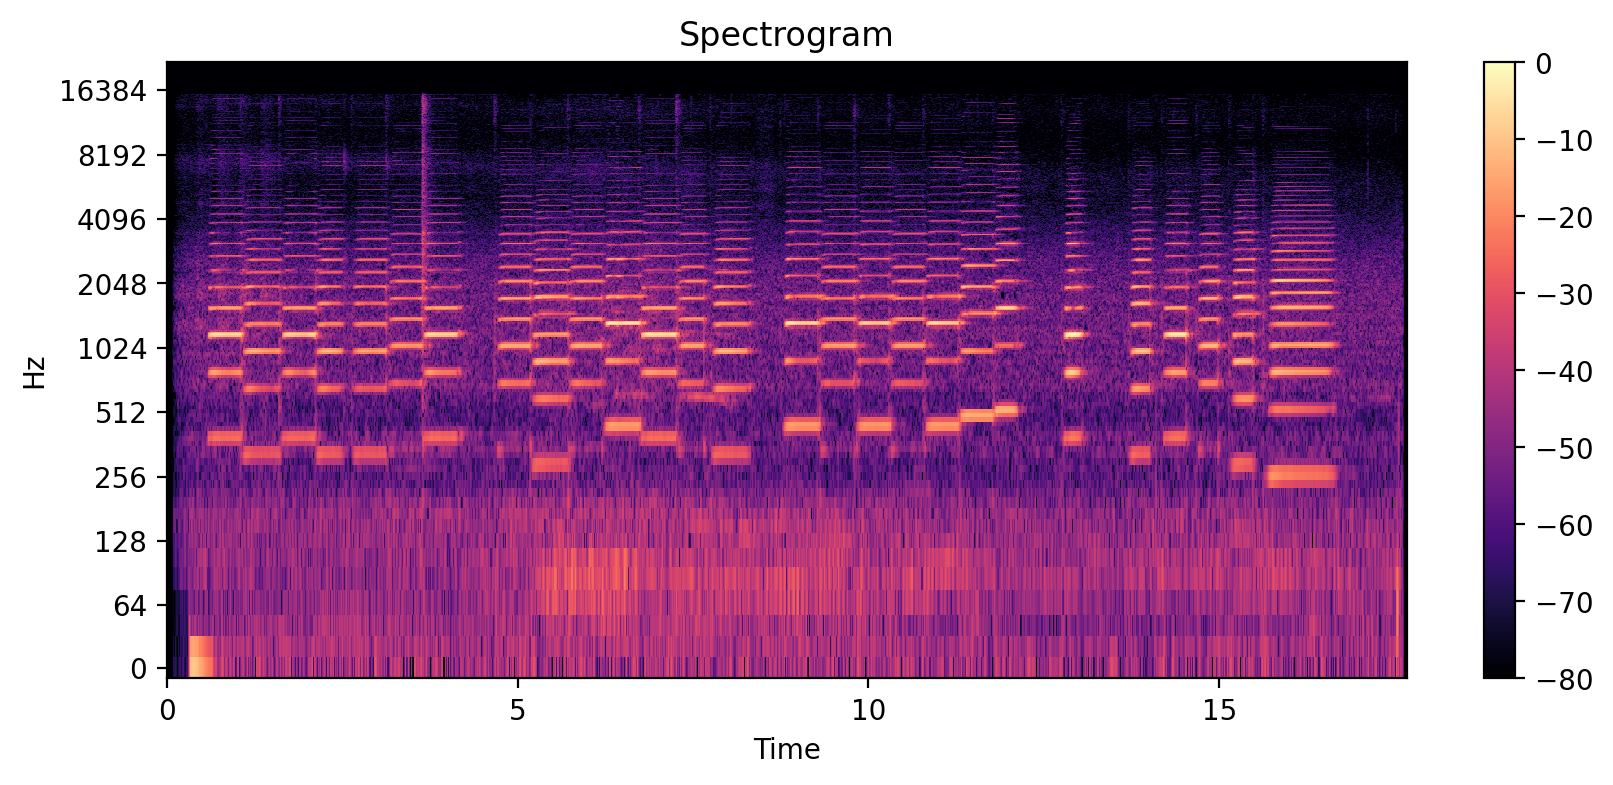

In [54]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def load_audio(file_path, sr=44100):
    audio, sr = librosa.load(file_path, sr=sr, mono=True)
    return audio, sr

def compute_spectrogram(audio, sr):
    stft = np.abs(librosa.stft(audio, n_fft=2048, hop_length=512))
    return librosa.amplitude_to_db(stft, ref=np.max)

file_path = "Cicak - Cicak Di Dinding Pianika NotAngka.wav"
audio, sr = load_audio(file_path)
spectrogram = compute_spectrogram(audio, sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, sr=sr, hop_length=512, x_axis="time", y_axis="log")
plt.colorbar()
plt.title("Spectrogram")
plt.show()


In [55]:
def detect_onsets(audio, sr):
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
    times = librosa.frames_to_time(onsets, sr=sr)
    return onsets, times

def estimate_pitch(audio, sr, onset_frames):
    pitches = []
    OCTAVE_SHIFT = 12  # naik 1 oktaf kalo perlu

    for onset in onset_frames:
        frame_start = librosa.frames_to_samples(onset)
        frame_end = frame_start + 4096  # longer frame: ~93ms at 44.1kHz

        if frame_end > len(audio):
            frame_end = len(audio)

        frame_audio = audio[frame_start:frame_end]

        if len(frame_audio) < 512:
            continue  # nada yang terlalu pendek dihilangkan


        pitch = librosa.yin(
            frame_audio,
            fmin=librosa.note_to_hz("C3"),
            fmax=librosa.note_to_hz("C6"),
            sr=sr
        )

        pitch = pitch[pitch != 0]  # 0 dikeluarkan

        if len(pitch) > 0:
            midi_note = librosa.hz_to_midi(np.median(pitch))
            midi_note = int(round(midi_note))

            # ubah nada kalau terlalu rendah aja
            if midi_note < 60:  # middle c
                midi_note += OCTAVE_SHIFT

            pitches.append(midi_note)
        else:
            pitches.append(60)  # balik ke middle c

    return pitches



onsets, onset_times = detect_onsets(audio, sr)
midi_pitches = estimate_pitch(audio, sr, onsets)

print("Detected onsets:", onset_times)
print("Detected MIDI pitches:", midi_pitches)


Detected onsets: [ 0.09287982  0.33668934  0.44117914  0.60371882  1.05650794  1.61378685
  2.12462585  2.54258503  2.64707483  3.13469388  3.64553288  4.67882086
  4.74848073  5.18965986  5.72371882  6.21133787  6.29260771  6.43192744
  6.74539683  7.2678458   7.67419501  7.75546485  7.84834467  8.82358277
  9.28798186  9.81043084 10.30965986 10.79727891 10.89015873 11.35455782
 11.84217687 12.77097506 12.81741497 13.7229932  13.76943311 14.02485261
 14.11773243 14.19900227 14.26866213 14.54730159 14.68662132 14.73306122
 15.0000907  15.15102041 15.22068027 15.49931973 15.63863946 15.74312925
 17.13632653 17.57750567]
Detected MIDI pitches: [75, 84, 75, 67, 64, 67, 64, 64, 64, 65, 67, 65, 65, 62, 65, 69, 69, 69, 67, 65, 62, 64, 64, 69, 65, 69, 65, 69, 69, 71, 72, 67, 67, 64, 64, 64, 64, 67, 67, 67, 65, 65, 65, 62, 62, 62, 60, 60, 61, 72]


In [56]:
def quantize_durations(onset_times):
    durations = []
    for i in range(len(onset_times) - 1):
        duration = onset_times[i + 1] - onset_times[i]
        if duration < 0.35:
            durations.append(0.5)  # eighth note
        elif duration < 0.75:
            durations.append(1.0)  # quarter note
        elif duration < 1.5:
            durations.append(2.0)  # half note
        else:
            durations.append(4.0)  # whole note
    durations.append(1.0)
    return durations


note_durations = quantize_durations(onset_times)
print("Quantized Durations:", note_durations)


Quantized Durations: [0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 2.0, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 2.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 2.0, 0.5, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 2.0, 1.0, 1.0]


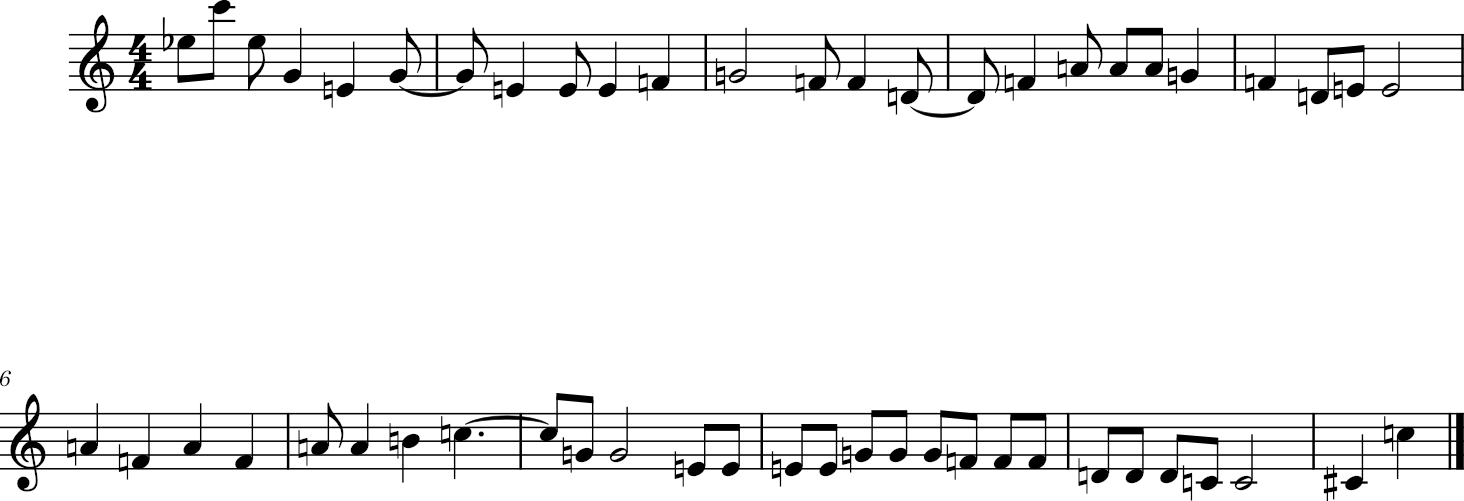

In [59]:
from music21 import stream, note, meter, clef, key, environment
from music21 import environment
import os

env = environment.UserSettings()
env['musescoreDirectPNGPath'] = os.path.abspath("MuseScorePortable/App/MuseScore/bin/MuseScore4.exe")


def create_sheet_music(midi_pitches, note_durations):
    score = stream.Score()
    part = stream.Part()
    part.append(clef.TrebleClef())
    part.append(meter.TimeSignature("4/4"))
    part.append(key.Key("C"))

    for i in range(len(midi_pitches)):
        n = note.Note(midi_pitches[i], quarterLength=note_durations[i])
        part.append(n)

    score.append(part)
    return score

min_len = min(len(midi_pitches), len(note_durations))
midi_pitches = midi_pitches[:min_len]
note_durations = note_durations[:min_len]


sheet_music = create_sheet_music(midi_pitches, note_durations)
sheet_music.show()


In [ ]:
sheet_music.write("musicxml", "output.xml")
sheet_music.write("midi", "output.mid")
